In [39]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from scipy.ndimage import uniform_filter1d

# EEG loading (EEGBCI dataset)

|    Runs   |                 Task                |
|:----------|:------------------------------------|
| 1         | Baseline, eyes open                 |
| 2         | Baseline, eyes closed               |
| 3, 7, 11  | Motor execution: left vs right hand |
| 4, 8, 12  | Motor imagery: left vs right hand   |
| 5, 9, 13  | Motor execution: hands vs feet      |
| 6, 10, 14 | Motor imagery: hands vs feet        |

Information extracted from: [MNE docs](https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html#mne.datasets.eegbci.load_data)

In [36]:
# Define the parameters 
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)
motor_imagery_data = raw_obj.get_data()

runs = [4, 8, 12]  # use only motor execution (left vs right)

#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)
motor_exec_data = raw_obj.get_data()

Extracting EDF parameters from /home/mariano/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., Cz.., C2.., C4.., C6.., Cp5., Cp3., Cp1., Cpz., Cp2., Cp4., Cp6., Fp1., Fpz., Fp2., Af7., Af3., Afz., Af4., Af8., F7.., F5.., F3.., F1.., Fz.., F2.., F4.., F6.., F8.., Ft7., Ft8., T7.., T8.., T9.., T10., Tp7., Tp8., P7.., P5.., P3.., P1.., Pz.., P2.., P4.., P6.., P8.., Po7., Po3., Poz., Po4., Po8., O1.., Oz.., O2.., Iz..
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/mariano/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4.

<IPython.core.display.Javascript object>


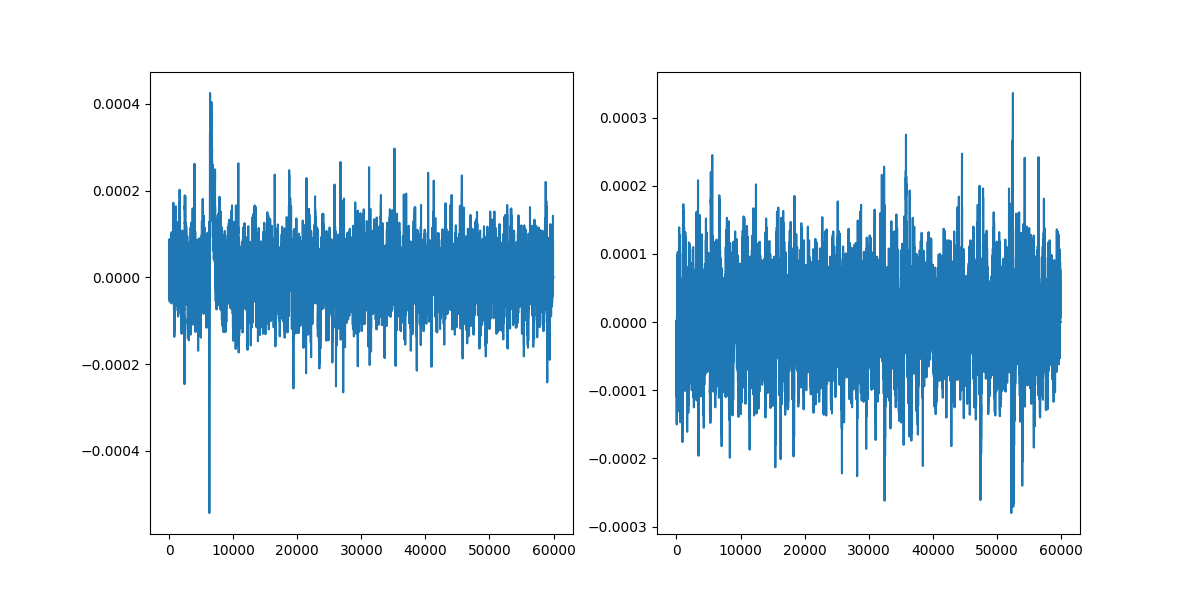

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(motor_imagery_data.transpose()[:, 1])
plt.subplot(1, 2, 2)
_ = plt.plot(motor_exec_data.transpose()[:, 1])

<IPython.core.display.Javascript object>


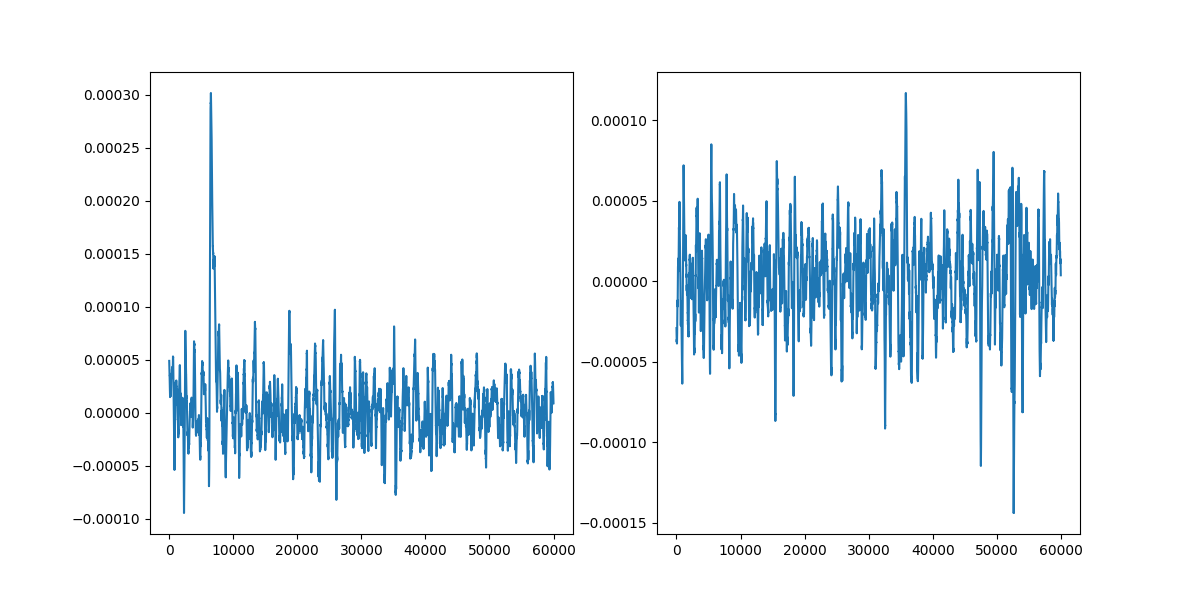

In [46]:
fmotor_imagery_data = np.stack([
    uniform_filter1d(signal, 500, mode='nearest')
    for signal in motor_imagery_data
])
fmotor_exec_data = np.stack([
    uniform_filter1d(signal, 500, mode='nearest')
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(fmotor_imagery_data.transpose()[:, 1])
plt.subplot(1, 2, 2)
_ = plt.plot(fmotor_exec_data.transpose()[:, 1])